### EDA- Censos Argentina

In [1]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import read_table_into_dataframe


In [2]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [3]:
# Read poblacion
df = read_table_into_dataframe('public.poblacion')
if df is not None:
    print(df)

      id AñoCenso CodigoDpto            Departamento  Poblacion   Varones  \
0    206     1991       6028         Almirante Brown   450698.0  222042.0   
1    207     1991       6035              Avellaneda   344991.0  164243.0   
2    208     1991       6091             Berazategui   244929.0  120870.0   
3    209     1991       6260  Esteban Echeverría (1)   275793.0  136784.0   
4    210     1991       6270              Ezeiza (2)        NaN       NaN   
..   ...      ...        ...                     ...        ...       ...   
200  406     2022       6756              San Isidro   298777.0  139818.0   
201  407     2022       6760              San Miguel   326215.0  157244.0   
202  408     2022       6805                   Tigre   447785.0  215056.0   
203  409     2022       6840         Tres de Febrero   366377.0  173299.0   
204  410     2022       6861           Vicente López   283510.0  131723.0   

      Mujeres  VivPartTot  VivColectTot  IndMasc  Superficie  DensPob  
0  

In [4]:
# Read vCensosAmba
df = read_table_into_dataframe('public.v_censos_amba')
if df is not None:
    print(df)

                nam cod_depto  anio       pob       var       muj   vivpart  \
0       José C. Paz     06412  2022  323918.0  157631.0  165831.0   97098.0   
1       José C. Paz     06412  2010  265981.0  131291.0  134690.0   72243.0   
2       José C. Paz     06412  2001  230208.0  114134.0  116074.0   59674.0   
3       José C. Paz     06412  1991       NaN       NaN       NaN       NaN   
4     Vicente López     06861  2022  283510.0  131723.0  149903.0  126139.0   
..              ...       ...   ...       ...       ...       ...       ...   
91  Lomas de Zamora     06490  1991  574330.0  278877.0  295453.0       NaN   
92       Avellaneda     06035  2022  370939.0  174572.0  194911.0  144988.0   
93       Avellaneda     06035  2010  342677.0  162264.0  180413.0  121307.0   
94       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   
95       Avellaneda     06035  1991  344991.0  164243.0  180748.0       NaN   

    vivtotal  Superficie     sup ind_masc dens_pob 

In [5]:
df.describe()
df.shape
df.columns
df.dtypes
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nam         96 non-null     object 
 1   cod_depto   96 non-null     object 
 2   anio        96 non-null     object 
 3   pob         90 non-null     float64
 4   var         90 non-null     float64
 5   muj         90 non-null     float64
 6   vivpart     72 non-null     float64
 7   vivtotal    72 non-null     float64
 8   Superficie  18 non-null     float64
 9   sup         96 non-null     object 
 10  ind_masc    90 non-null     object 
 11  dens_pob    90 non-null     object 
dtypes: float64(6), object(6)
memory usage: 9.1+ KB


nam            0
cod_depto      0
anio           0
pob            6
var            6
muj            6
vivpart       24
vivtotal      24
Superficie    78
sup            0
ind_masc       6
dens_pob       6
dtype: int64

In [6]:
numeric_features=[feature for feature in df.columns if df[feature].dtype !='O']

categorical_features=[feature for feature in df.columns if df[feature].dtype =='O']
print(f" We have {len(numeric_features)} number of numerical features ",numeric_features)
print(f" We have {len(categorical_features)} number of Categorical features ",categorical_features)

 We have 6 number of numerical features  ['pob', 'var', 'muj', 'vivpart', 'vivtotal', 'Superficie']
 We have 6 number of Categorical features  ['nam', 'cod_depto', 'anio', 'sup', 'ind_masc', 'dens_pob']


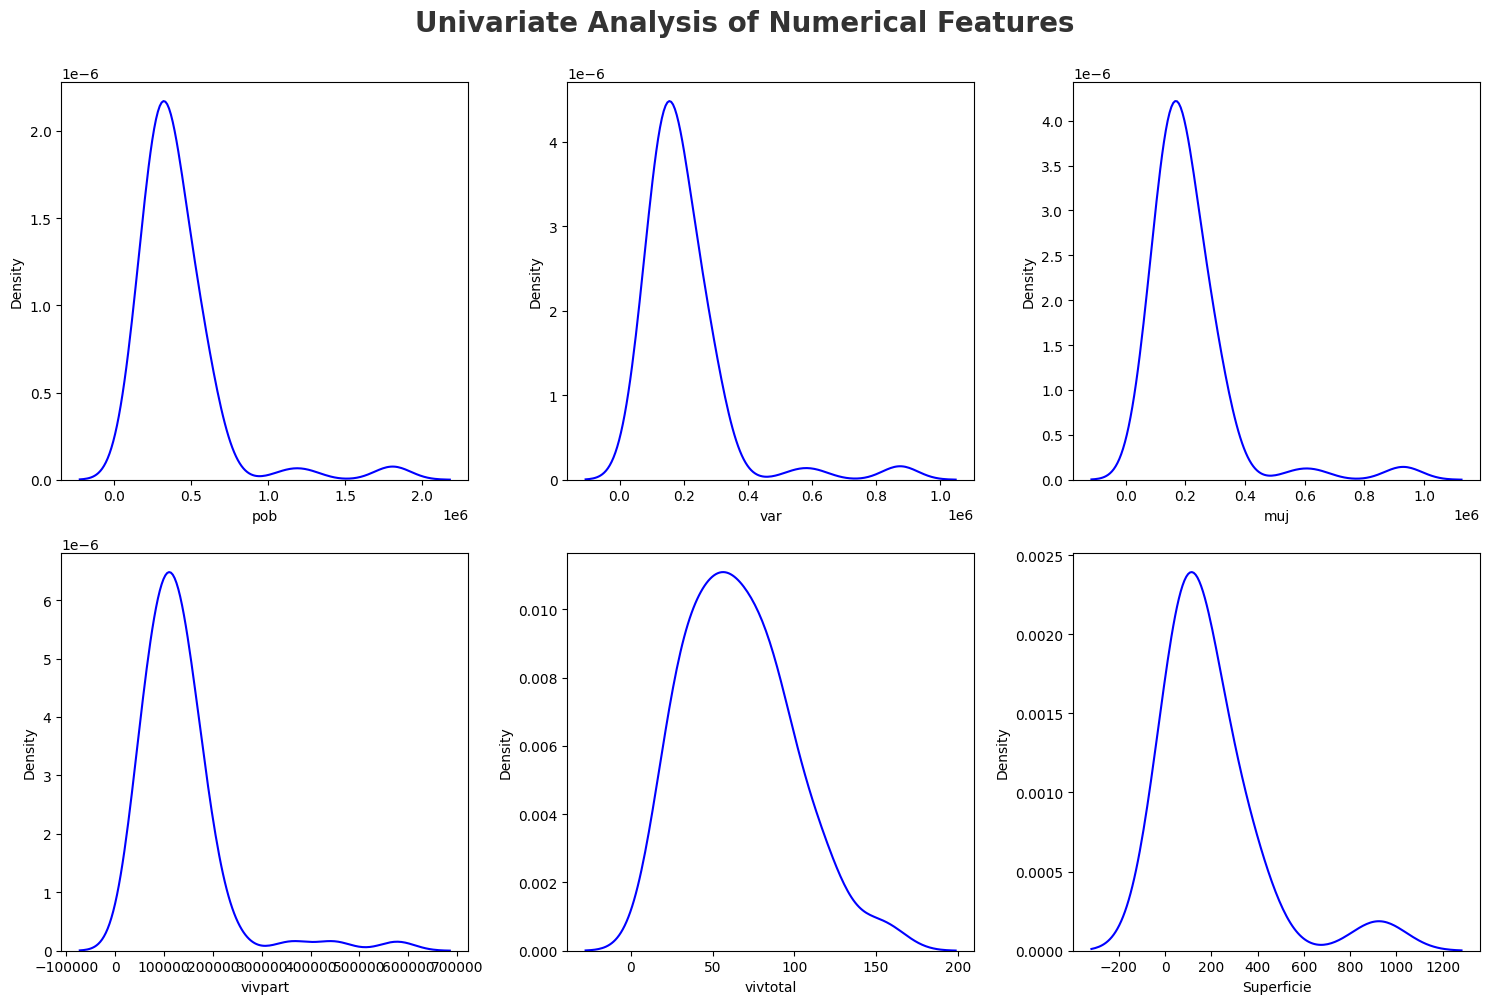

In [7]:
plt.figure(figsize=(15,10))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold',alpha=0.8, y=1.) 

for i in range(0, len(numeric_features)):
    plt.subplot(2,3, i+1)
    sns.kdeplot(x=df[numeric_features[i]], color='blue')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

In [ ]:
## NAN VALUES
nan_values = df.isna().sum()
print(nan_values)

## Fill NAN values with none
df_filled = df.fillna(0)     ## Specific columm -->##{'pob': 0}
nan_values = df_filled.isna().sum()
print(nan_values)
df=df_filled



# df_filled = df.fillna({'pob': 0})
# nan_values = df_filled.isna().sum()
# print(nan_values)
# df=df_filled

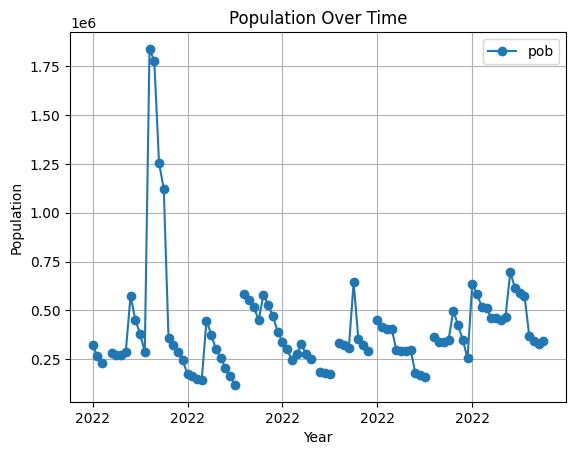

In [8]:
df.plot(x='anio', y='pob', kind='line', marker='o')  # 'line' plot with markers
plt.title('Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()


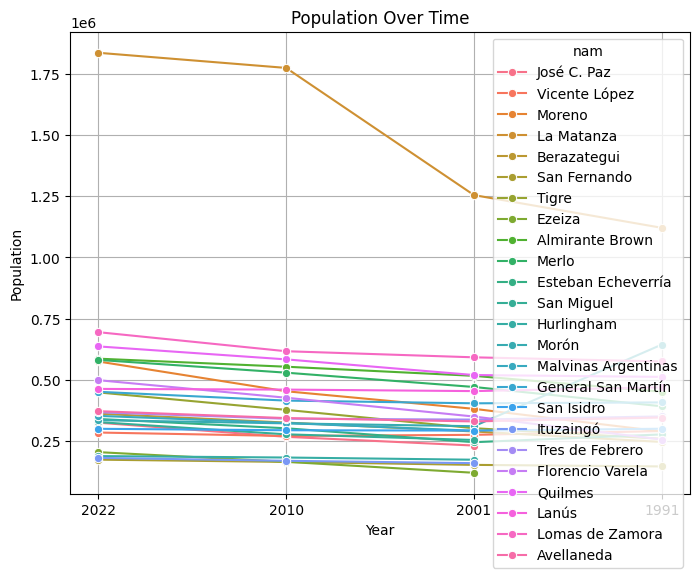

In [9]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='anio', y='pob',hue='nam', marker='o')
plt.title('Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()

In [75]:
# import custom fucntions
from utils import categorize_dens_pob
from utils import categorize_sup

# Apply the function to create a new column
df['sup_category'] = df['sup'].apply(categorize_sup)
df_cleaned = df.dropna(subset=['dens_pob'])
df=df_cleaned
df['dens_category'] = df['dens_pob'].apply(categorize_dens_pob)
df = df.sort_values(by='anio')
# Check the DataFrame after categorizing
print(df)


                   nam cod_depto  anio       pob       var       muj  \
95          Avellaneda     06035  1991  344991.0  164243.0  180748.0   
79    Florencio Varela     06274  1991  254997.0  127717.0  127280.0   
35     Almirante Brown     06028  1991  450698.0  222042.0  228656.0   
7        Vicente López     06861  1991  289505.0  135426.0  154079.0   
87               Lanús     06434  1991  468561.0  224537.0  244024.0   
..                 ...       ...   ...       ...       ...       ...   
40  Esteban Echeverría     06260  2022  339030.0  163974.0  174468.0   
32     Almirante Brown     06028  2022  585852.0  281842.0  301779.0   
44          San Miguel     06760  2022  326215.0  157244.0  168569.0   
80             Quilmes     06658  2022  636026.0  304299.0  329672.0   
0          José C. Paz     06412  2022  323918.0  157631.0  165831.0   

     vivpart  vivtotal  Superficie     sup ind_masc dens_pob sup_category  \
95       NaN       NaN        55.0   68.54     90.9  5033.

In [ ]:
# Grouping the data by the specified column (replace 'column_name' with the actual column name)
grouped_df = df.groupby('dens_category')

# Plotting each group separately
plt.figure(figsize=(8, 6))
for name, group in grouped_df:
    sns.lineplot(data=group, x='anio', y='pob', marker='o' ,label=name)

plt.title('Population Over Time by Category')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(title='Category')
plt.grid(True)
plt.show()




In [ ]:

# Create a FacetGrid with a plot for each distinct value in 'dens_category'
g = sns.FacetGrid(df, col='dens_category', col_wrap=3, height=4)
g.map(sns.lineplot, 'anio', 'pob', 'nam', marker='o')
g.set_titles('{col_name}')
g.set_axis_labels('Year', 'Population')
g.tight_layout()
plt.show()


In [ ]:
# Create a count plot for the 'dens_category' column
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='dens_category')
plt.title('Density Category Distribution')
plt.xlabel('Density Category')
plt.ylabel('Count')
plt.show()

In [ ]:
# Filter the DataFrame for rows where dens_category is 'baja'
df_baja = df[df['dens_category'] == 'baja']
# Sort the DataFrame by the 'anio' column
df_baja_sorted = df_baja.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_baja_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time Densidad Baja')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()

# Filter the DataFrame for rows where dens_category is 'baja'
df_media = df[df['dens_category'] == 'media']
# Sort the DataFrame by the 'anio' column
df_media_sorted = df_media.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_media_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time- Densidad MEDIA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()
# Filter the DataFrame for rows where dens_category is 'media-alta'
df_media_alta = df[df['dens_category'] == 'media-alta']
# Sort the DataFrame by the 'anio' column
df_media_alta_sorted = df_media_alta.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_media_alta_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time- Densidad MEDIA ALTA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()
 #Filter the DataFrame for rows where dens_category is 'media-alta'
df_alta = df[df['dens_category'] == 'alta']
# Sort the DataFrame by the 'anio' column
# Sort the DataFrame by the 'anio' column
df_alta_sorted = df_alta.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_alta_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time- Densidad ALTA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()

In [ ]:
print( df[df['nam'] == 'La Matanza'])
### DENSIDAD
df = df.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='anio', y='dens_pob',hue='nam',palette='dark', marker='o')
plt.title('Densidad Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)

In [ ]:
# Sort the DataFrame by 'anio'
df_sorted = df.sort_values(by='anio')

# Calculate the growth ratio (percentage change) for 'pob' for each city ('nam') and each year ('anio')
df_sorted['growth_ratio'] = df_sorted.groupby('nam')['pob'].pct_change() * 100

# Display the DataFrame with the growth ratio
print(df_sorted[['nam', 'anio', 'pob', 'growth_ratio']])


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sorted, x='anio', y='growth_ratio', hue='nam',palette='dark', marker='o')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each City')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='City', loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


C:\Users\Fer\AppData\Local\Temp\ipykernel_13108\523077788.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cluster'] = kmeans.fit_predict(X)


                   nam  growth_ratio  cluster
78    Florencio Varela     36.852590        2
6        Vicente López     -5.327369        3
14          La Matanza     11.949544        0
18         Berazategui     17.549576        0
34     Almirante Brown     14.390568        0
..                 ...           ...      ...
20        San Fernando      5.687332        3
44          San Miguel     18.112531        0
60  General San Martín      8.725096        0
36               Merlo      9.898315        0
0          José C. Paz     21.782383        0

[66 rows x 3 columns]
Cluster Centers (Mean Growth Ratio):
cluster
0    13.630223
1   -51.926259
2    30.972242
3     1.635725
Name: growth_ratio, dtype: float64


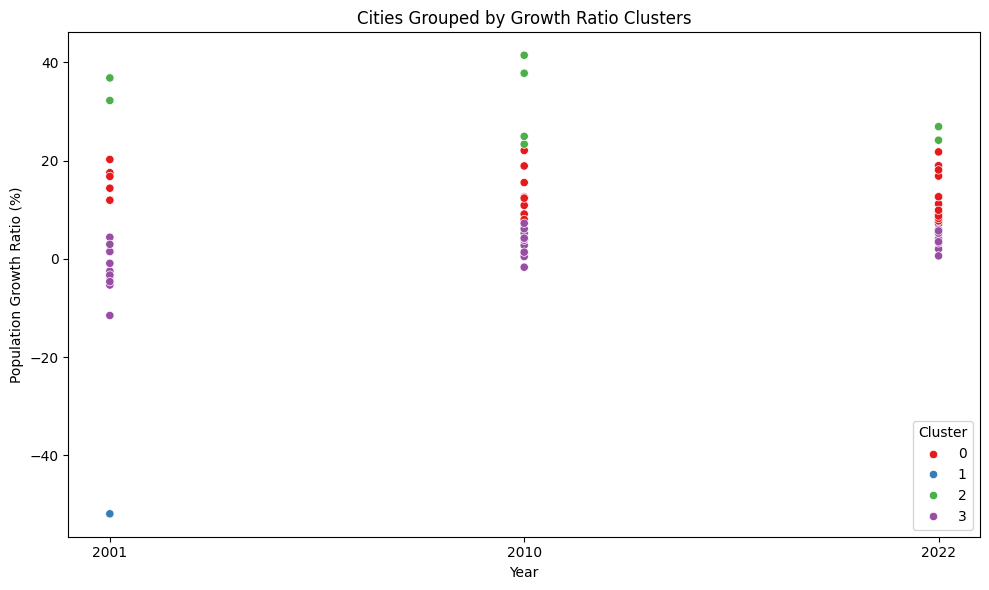

In [90]:

# Drop rows with NaN growth ratios
df_cleaned = df_sorted.dropna(subset=['growth_ratio'])

# Select the growth ratio column for clustering
X = df_cleaned[['growth_ratio']]

# Define the number of clusters (you can adjust this based on your preference)
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X)

# Display the DataFrame with cluster assignments
print(df_cleaned[['nam', 'growth_ratio', 'cluster']])

# Calculate cluster centers (mean growth ratio) for each cluster
cluster_centers = df_cleaned.groupby('cluster')['growth_ratio'].mean()
print("Cluster Centers (Mean Growth Ratio):")
print(cluster_centers)


# Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='anio', y='growth_ratio', hue='cluster', palette='Set1', marker='o')

# Set plot title and labels
plt.title('Cities Grouped by Growth Ratio Clusters')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Show legend
plt.legend(title='Cluster')

# Show plot
plt.tight_layout()
plt.show()


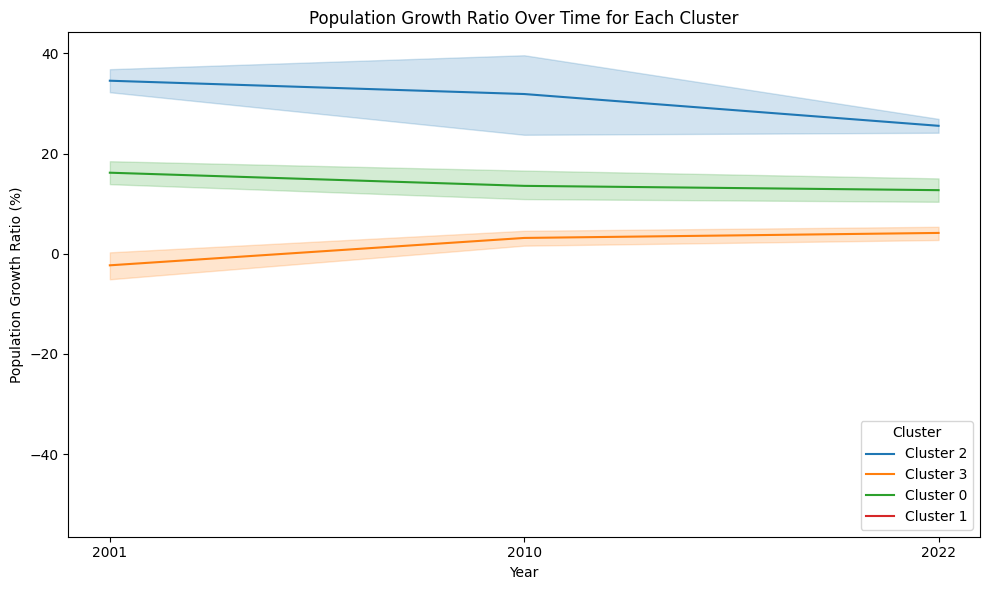

In [88]:
# Create a line plot for growth ratio by year for each cluster
plt.figure(figsize=(10, 6))
for cluster_id in df_cleaned['cluster'].unique():
    cluster_data = df_cleaned[df_cleaned['cluster'] == cluster_id]
    sns.lineplot(data=cluster_data, x='anio', y='growth_ratio', label=f'Cluster {cluster_id}')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Show legend
plt.legend(title='Cluster')

# Show plot
plt.tight_layout()
plt.show()


In [93]:
# Assuming df_cleaned contains the DataFrame with growth ratios and cluster assignments

# Iterate over unique cluster IDs and print rows for each cluster
for cluster_id in df_cleaned['cluster'].unique():
    cluster_data = df_cleaned[df_cleaned['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:\n{cluster_data}\n")


Cluster 2:
                   nam cod_depto  anio        pob       var       muj  \
78    Florencio Varela     06274  2001   348970.0  174590.0  174380.0   
10              Moreno     06560  2001   380503.0  188392.0  192111.0   
29              Ezeiza     06270  2010   163722.0   81902.0   81820.0   
41  Esteban Echeverría     06260  2010   300959.0  147980.0  152979.0   
25               Tigre     06805  2010   376381.0  184774.0  191607.0   
13          La Matanza     06427  2010  1775816.0  866690.0  909126.0   
8               Moreno     06560  2022   574374.0  280118.0  293251.0   
28              Ezeiza     06270  2022   203283.0   97766.0  102703.0   

     vivpart  vivtotal  Superficie     sup ind_masc dens_pob sup_category  \
78   91293.0      53.0         NaN  231.51    100.1  1507.36   muy grande   
10  108521.0      58.0         NaN  226.81     98.1  1677.63       grande   
29   49210.0      26.0         NaN  291.00    100.1   562.62   muy grande   
41   88164.0      26.0 

                   nam cod_depto  anio        pob       var       muj  \
78    Florencio Varela     06274  2001   348970.0  174590.0  174380.0   
10              Moreno     06560  2001   380503.0  188392.0  192111.0   
29              Ezeiza     06270  2010   163722.0   81902.0   81820.0   
41  Esteban Echeverría     06260  2010   300959.0  147980.0  152979.0   
25               Tigre     06805  2010   376381.0  184774.0  191607.0   
13          La Matanza     06427  2010  1775816.0  866690.0  909126.0   
8               Moreno     06560  2022   574374.0  280118.0  293251.0   
28              Ezeiza     06270  2022   203283.0   97766.0  102703.0   

     vivpart  vivtotal  Superficie     sup ind_masc dens_pob sup_category  \
78   91293.0      53.0         NaN  231.51    100.1  1507.36   muy grande   
10  108521.0      58.0         NaN  226.81     98.1  1677.63       grande   
29   49210.0      26.0         NaN  291.00    100.1   562.62   muy grande   
41   88164.0      26.0         NaN

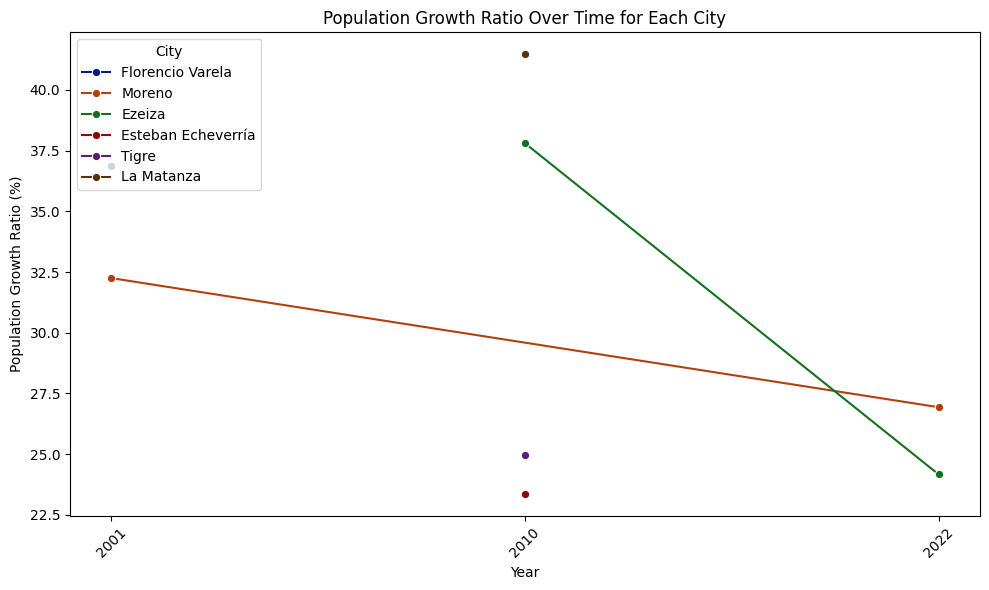

In [116]:

cluster_2_data = df_cleaned[df_cleaned['cluster'] == 2]
print(cluster_2_data)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cluster_2_data, x='anio', y='growth_ratio', hue='nam',palette='dark', marker='o')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each City')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='City', loc='upper left')

# Show plot
plt.tight_layout()
plt.show()
print()


In [120]:
# Assuming df_cleaned contains the DataFrame with growth rates and cluster assignments

# Sort the DataFrame by the 'nam' column
df_cleaned_sorted = df_cleaned.sort_values(by='nam')
distinct_nam_values = cluster_2_data['nam'].unique()

# Select rows from df_another where the 'nam' column is in the distinct values obtained
cluster2cities = df_cleaned_sorted[df_cleaned_sorted['nam'].isin(distinct_nam_values)]

# Display selected rows
print(cluster2cities)


                   nam cod_depto  anio        pob       var       muj  \
42  Esteban Echeverría     06260  2001   243974.0  120110.0  123864.0   
41  Esteban Echeverría     06260  2010   300959.0  147980.0  152979.0   
40  Esteban Echeverría     06260  2022   339030.0  163974.0  174468.0   
29              Ezeiza     06270  2010   163722.0   81902.0   81820.0   
28              Ezeiza     06270  2022   203283.0   97766.0  102703.0   
77    Florencio Varela     06274  2010   426005.0  212909.0  213096.0   
76    Florencio Varela     06274  2022   497818.0  239305.0  250192.0   
78    Florencio Varela     06274  2001   348970.0  174590.0  174380.0   
14          La Matanza     06427  2001  1255288.0  612967.0  642321.0   
13          La Matanza     06427  2010  1775816.0  866690.0  909126.0   
12          La Matanza     06427  2022  1837774.0  883023.0  950847.0   
10              Moreno     06560  2001   380503.0  188392.0  192111.0   
9               Moreno     06560  2010   452505.0  

In [121]:
# Assuming df_cleaned contains the DataFrame with growth rates and cluster assignments

# Calculate the standard deviation of growth rates for each city
std_deviation_per_city = cluster2cities.groupby('nam')['growth_ratio'].std()

# Calculate the coefficient of variation (CV) of growth rates for each city
mean_growth_rate_per_city = cluster2cities.groupby('nam')['growth_ratio'].mean()
cv_per_city = (std_deviation_per_city / mean_growth_rate_per_city) * 100

# Display the standard deviation and coefficient of variation per city
print("Standard Deviation of Growth Rates per City:")
print(std_deviation_per_city)
print("\nCoefficient of Variation (CV) of Growth Rates per City:")
print(cv_per_city)


Standard Deviation of Growth Rates per City:
nam
Esteban Echeverría    17.875829
Ezeiza                 9.645990
Florencio Varela      10.371541
La Matanza            19.938097
Moreno                 6.708700
Tigre                  4.225893
Name: growth_ratio, dtype: float64

Coefficient of Variation (CV) of Growth Rates per City:
nam
Esteban Echeverría    219.159491
Ezeiza                 31.131899
Florencio Varela       41.056513
La Matanza            105.111891
Moreno                 25.768040
Tigre                  20.882166
Name: growth_ratio, dtype: float64


In [ ]:
# Plot the standard deviation of growth rates per city
plt.figure(figsize=(10, 6))
std_deviation_per_city.plot(kind='bar', color='skyblue')
plt.title('Standard Deviation of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the coefficient of variation (CV) of growth rates per city
plt.figure(figsize=(10, 6))
cv_per_city.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
